In [1]:
# General
import sys
import os
import os.path as op
from time import time
from collections import OrderedDict as od
from importlib import reload
from glob import glob
import itertools
import h5py
import warnings

# Scientific
import numpy as np
import pandas as pd
pd.options.display.max_rows = 200
pd.options.display.max_columns = 999
import scipy.io as sio

# Stats
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import random
from sklearn.decomposition import PCA

# Plots
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
from matplotlib.lines import Line2D
import matplotlib.patches as patches
mpl.rcParams['grid.linewidth'] = 0.1
mpl.rcParams['grid.alpha'] = 0.75
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['lines.markersize'] = 3
mpl.rcParams['xtick.labelsize'] = 15
mpl.rcParams['ytick.labelsize'] = 15 
colors = ['1f77b4', 'd62728', '2ca02c', 'ff7f0e', '9467bd', 
          '8c564b', 'e377c2', '7f7f7f', 'bcbd22', '17becf']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', colors)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.formatter.offset_threshold'] = 2
mpl.rcParams['axes.labelsize'] = 17
mpl.rcParams['axes.labelpad'] = 10
mpl.rcParams['axes.titlesize'] = 19
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['legend.loc'] = 'upper right'
mpl.rcParams['legend.fontsize'] = 15
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['figure.titlesize'] = 19
mpl.rcParams['figure.figsize'] = (6.85039, 4.79527) 
mpl.rcParams['figure.subplot.wspace'] = 0.25 
mpl.rcParams['figure.subplot.hspace'] = 0.25 
mpl.rcParams['font.sans-serif'] = ['Helvetica']
mpl.rcParams['savefig.format'] = 'pdf'
mpl.rcParams['pdf.fonttype'] = 42

# Personal
sys.path.append('/home1/cjmac/code/general')
sys.path.append('/home1/cjmac/code/projects/manning_replication')
sys.path.append('/home1/cjmac/code/projects')
import data_io as dio
import array_operations as aop
from eeg_plotting import plot_trace, plot_trace2
from time_cells import spike_sorting, spike_preproc, events_preproc, events_proc, time_bin_analysis

# Colors
n = 4
c = 2
colors = [sns.color_palette('Blues', n)[c], 
          sns.color_palette('Reds', n)[c], 
          sns.color_palette('Greens', n)[c],
          sns.color_palette('Purples', n)[c],
          sns.color_palette('Oranges', n)[c],
          sns.color_palette('Greys', n)[c],
          sns.color_palette('YlOrBr', n+3)[c],
          'k']
cmap = sns.palettes.blend_palette((colors[0], 
                                   'w',
                                   colors[1]), 501)

font = {'tick': 12,
        'label': 14,
        'annot': 12,
        'fig': 16}

In /usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases

## Perform alignment

In [2]:
subj_sess = 'U540_ses0'

# Read events file and get event synctimes.
events, event_synctimes = events_preproc.read_events_json(subj_sess)

# Load LFP timestamps.
lfp_timestamps, sr = spike_sorting.load_lfp_timestamps(subj_sess)

# Load the sync channel.
sync_chan = events_preproc.load_syncs(subj_sess, data_key='data')

# Identify sync pulses in the sync channel EEG.
pulse_startinds = events_preproc.find_pulse_starts(sync_chan, 
                                                   sampling_rate=sr, 
                                                   pulse_thresh=200, 
                                                   intrapulse_thresh_ms=20, 
                                                   interpulse_thresh_ms=790)
lfp_synctimes = lfp_timestamps[pulse_startinds]
print('Detected {} syncs for {} sync pulse events'.format(len(pulse_startinds), len(events.loc[events.key=='syncPulse', 'time'])))

# Find matching sync pulse pairs.
event_synctimes_adj, lfp_synctimes_adj = events_preproc.pair_sync_pulses(event_synctimes, 
                                                                         lfp_synctimes, step=5, max_shift=200, max_slide=50, ipi_thresh=2)

# Perform the alignment.
alignment = events_preproc.align_sync_pulses(event_synctimes_adj, 
                                             lfp_synctimes_adj)

# Apply the alignment to all event times.
events['time'] = events['time'].apply(lambda x: alignment['sync_params']['intercept'] + (alignment['sync_params']['slope'] * x))

# How did our alignment go?
print('{} event sync pulses'.format(len(event_synctimes_adj)))
print('{} LFP sync pulses identified'.format(len(lfp_synctimes_adj)))
print('\n--------------------\nAlignment parameters\n--------------------')
for k, v in alignment.items():
    print('{}: {}'.format(k, v))

The first timestamp in events before zero-ing is 1627593194100.360
The first timestamp in events after zero-ing is 0.000
85458 events recorded over 68 min and 52 sec
The first timestamp in lfp_timestamps before zero-ing & before conv factor is 0.000
The first timestamp in lfp_timestamps before zero-ing & after conv factor is 0.000
The first timestamp in lfp_timestamps after zero-ing & conv factor is 0.000
Conversion factor is 1
123945508 timestamps over 68 min and 51.5 s
Sampling rate is 30000 Hz


/home1/cjmac/.local/lib/python3.7/site-packages/numpy/lib/function_base.py:1255: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = asanyarray(a)


ValueError: operands could not be broadcast together with shapes (0,) (123945508,) 

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


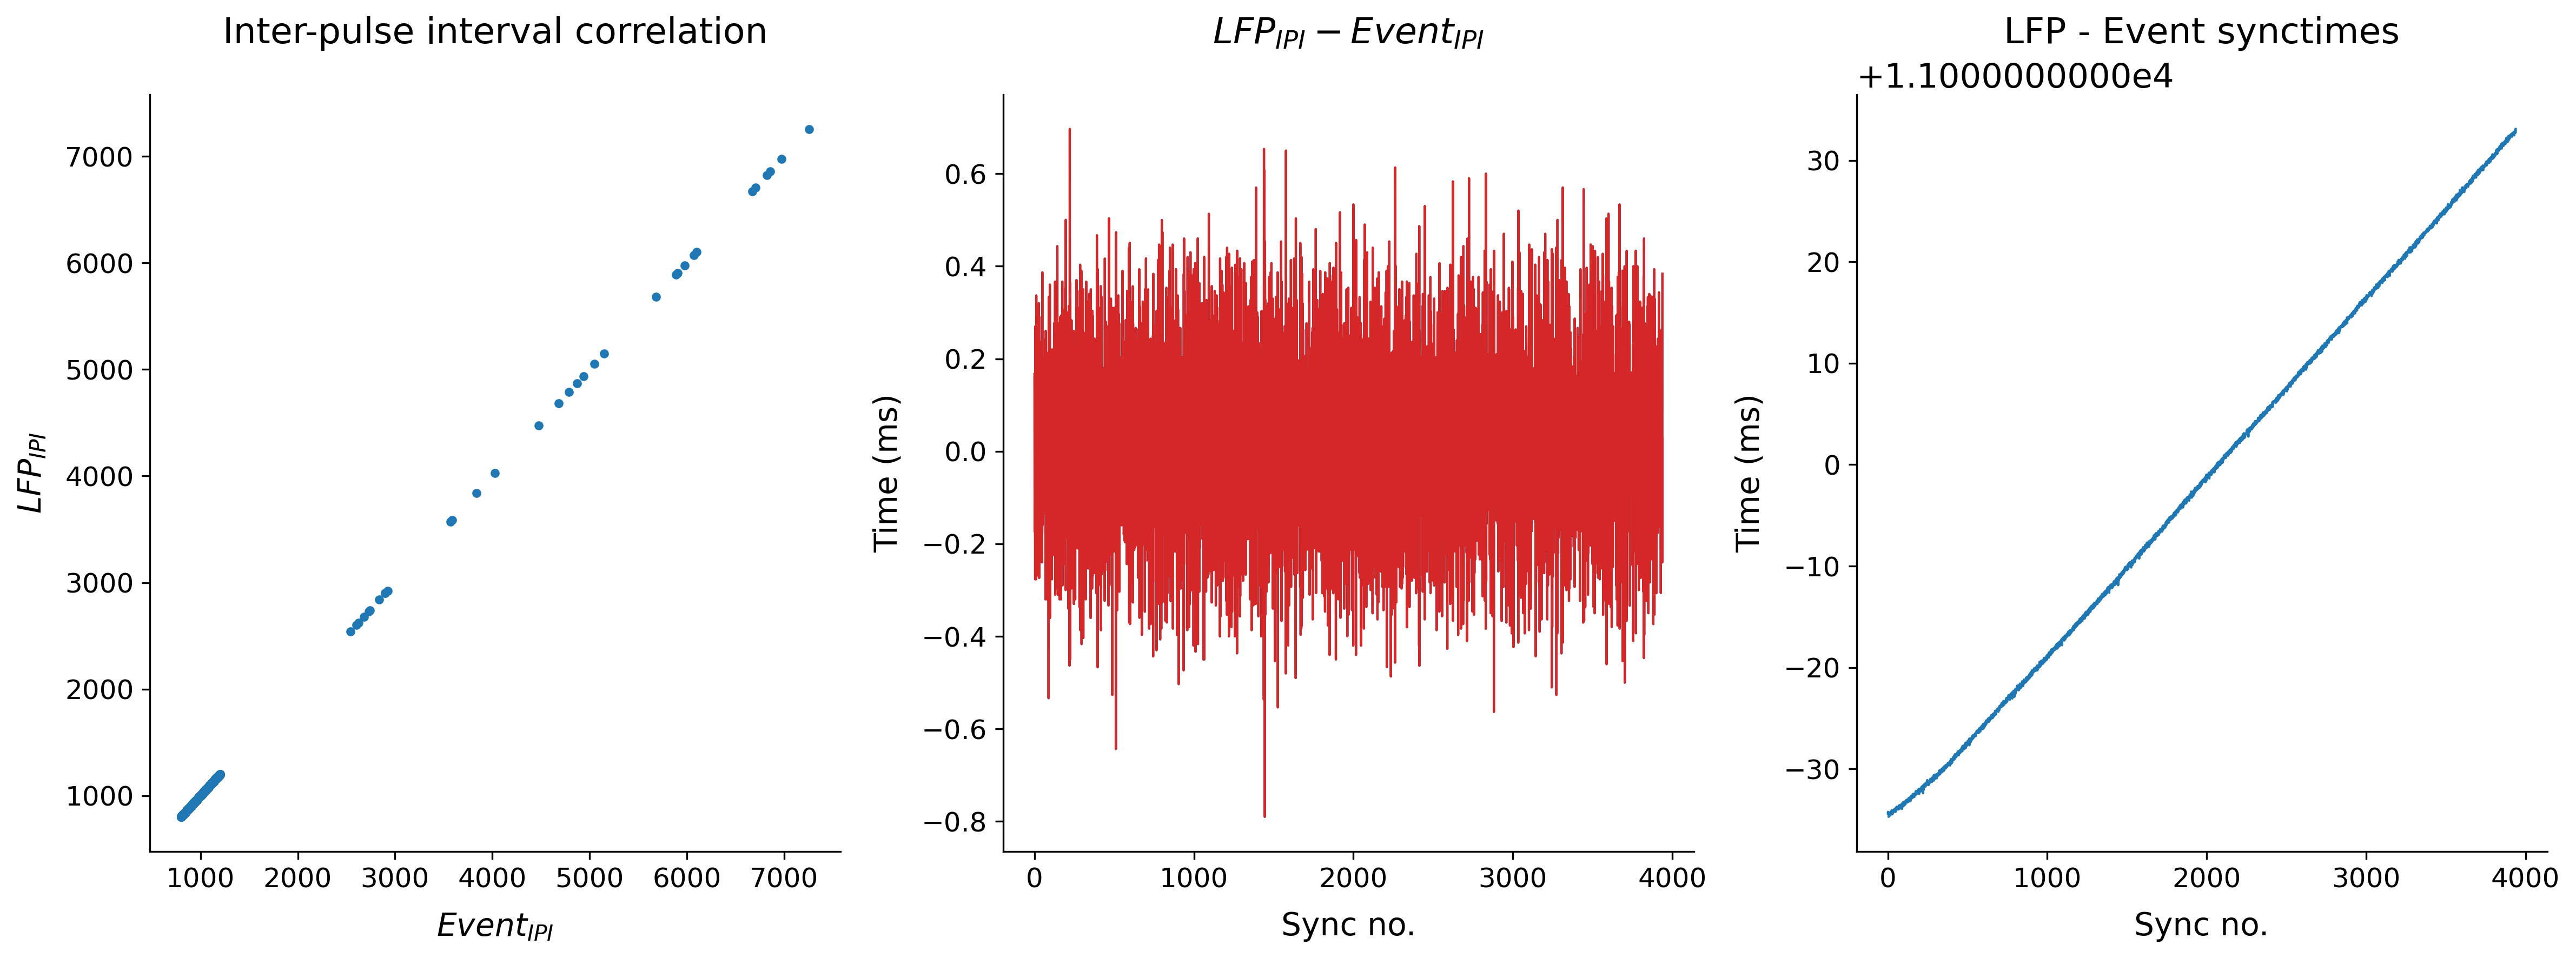

In [3]:
plt.close()
fig, ax = plt.subplots(1, 3, figsize=(16, 6), dpi=300)
ax = np.ravel(ax)

min_syncs = np.min((len(event_synctimes_adj), len(lfp_synctimes_adj)))
start = 0
stop = None

i = 0
ax[i].scatter(np.diff(event_synctimes_adj), np.diff(lfp_synctimes_adj))
ax[i].set_xlabel('$Event_{IPI}$', fontsize=font['label'], labelpad=8)
ax[i].set_ylabel('$LFP_{IPI}$', fontsize=font['label'], labelpad=8)
ax[i].set_title('Inter-pulse interval correlation', fontsize=font['fig'], y=1.05)

i = 1
ax[i].plot(np.diff(lfp_synctimes_adj)[start:stop] - np.diff(event_synctimes_adj)[start:stop])
ax[i].plot(np.diff(lfp_synctimes_adj)[start:stop] - np.diff(event_synctimes_adj)[start:stop])
ax[i].set_xlabel('Sync no.', fontsize=font['label'], labelpad=8)
ax[i].set_ylabel('Time (ms)', fontsize=font['label'], labelpad=8)
ax[i].set_title('$LFP_{IPI} - Event_{IPI}$', fontsize=font['fig'], y=1.05)

i = 2
ax[i].plot(lfp_synctimes_adj[start:stop] - event_synctimes_adj[start:stop])
ax[i].set_xlabel('Sync no.', fontsize=font['label'], labelpad=8)
ax[i].set_ylabel('Time (ms)', fontsize=font['label'], labelpad=8)
ax[i].set_title('LFP - Event synctimes', fontsize=font['fig'], y=1.05)

for i in range(len(ax)):
    ax[i].tick_params(axis='both', which='major', labelsize=font['tick'])
fig.tight_layout()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


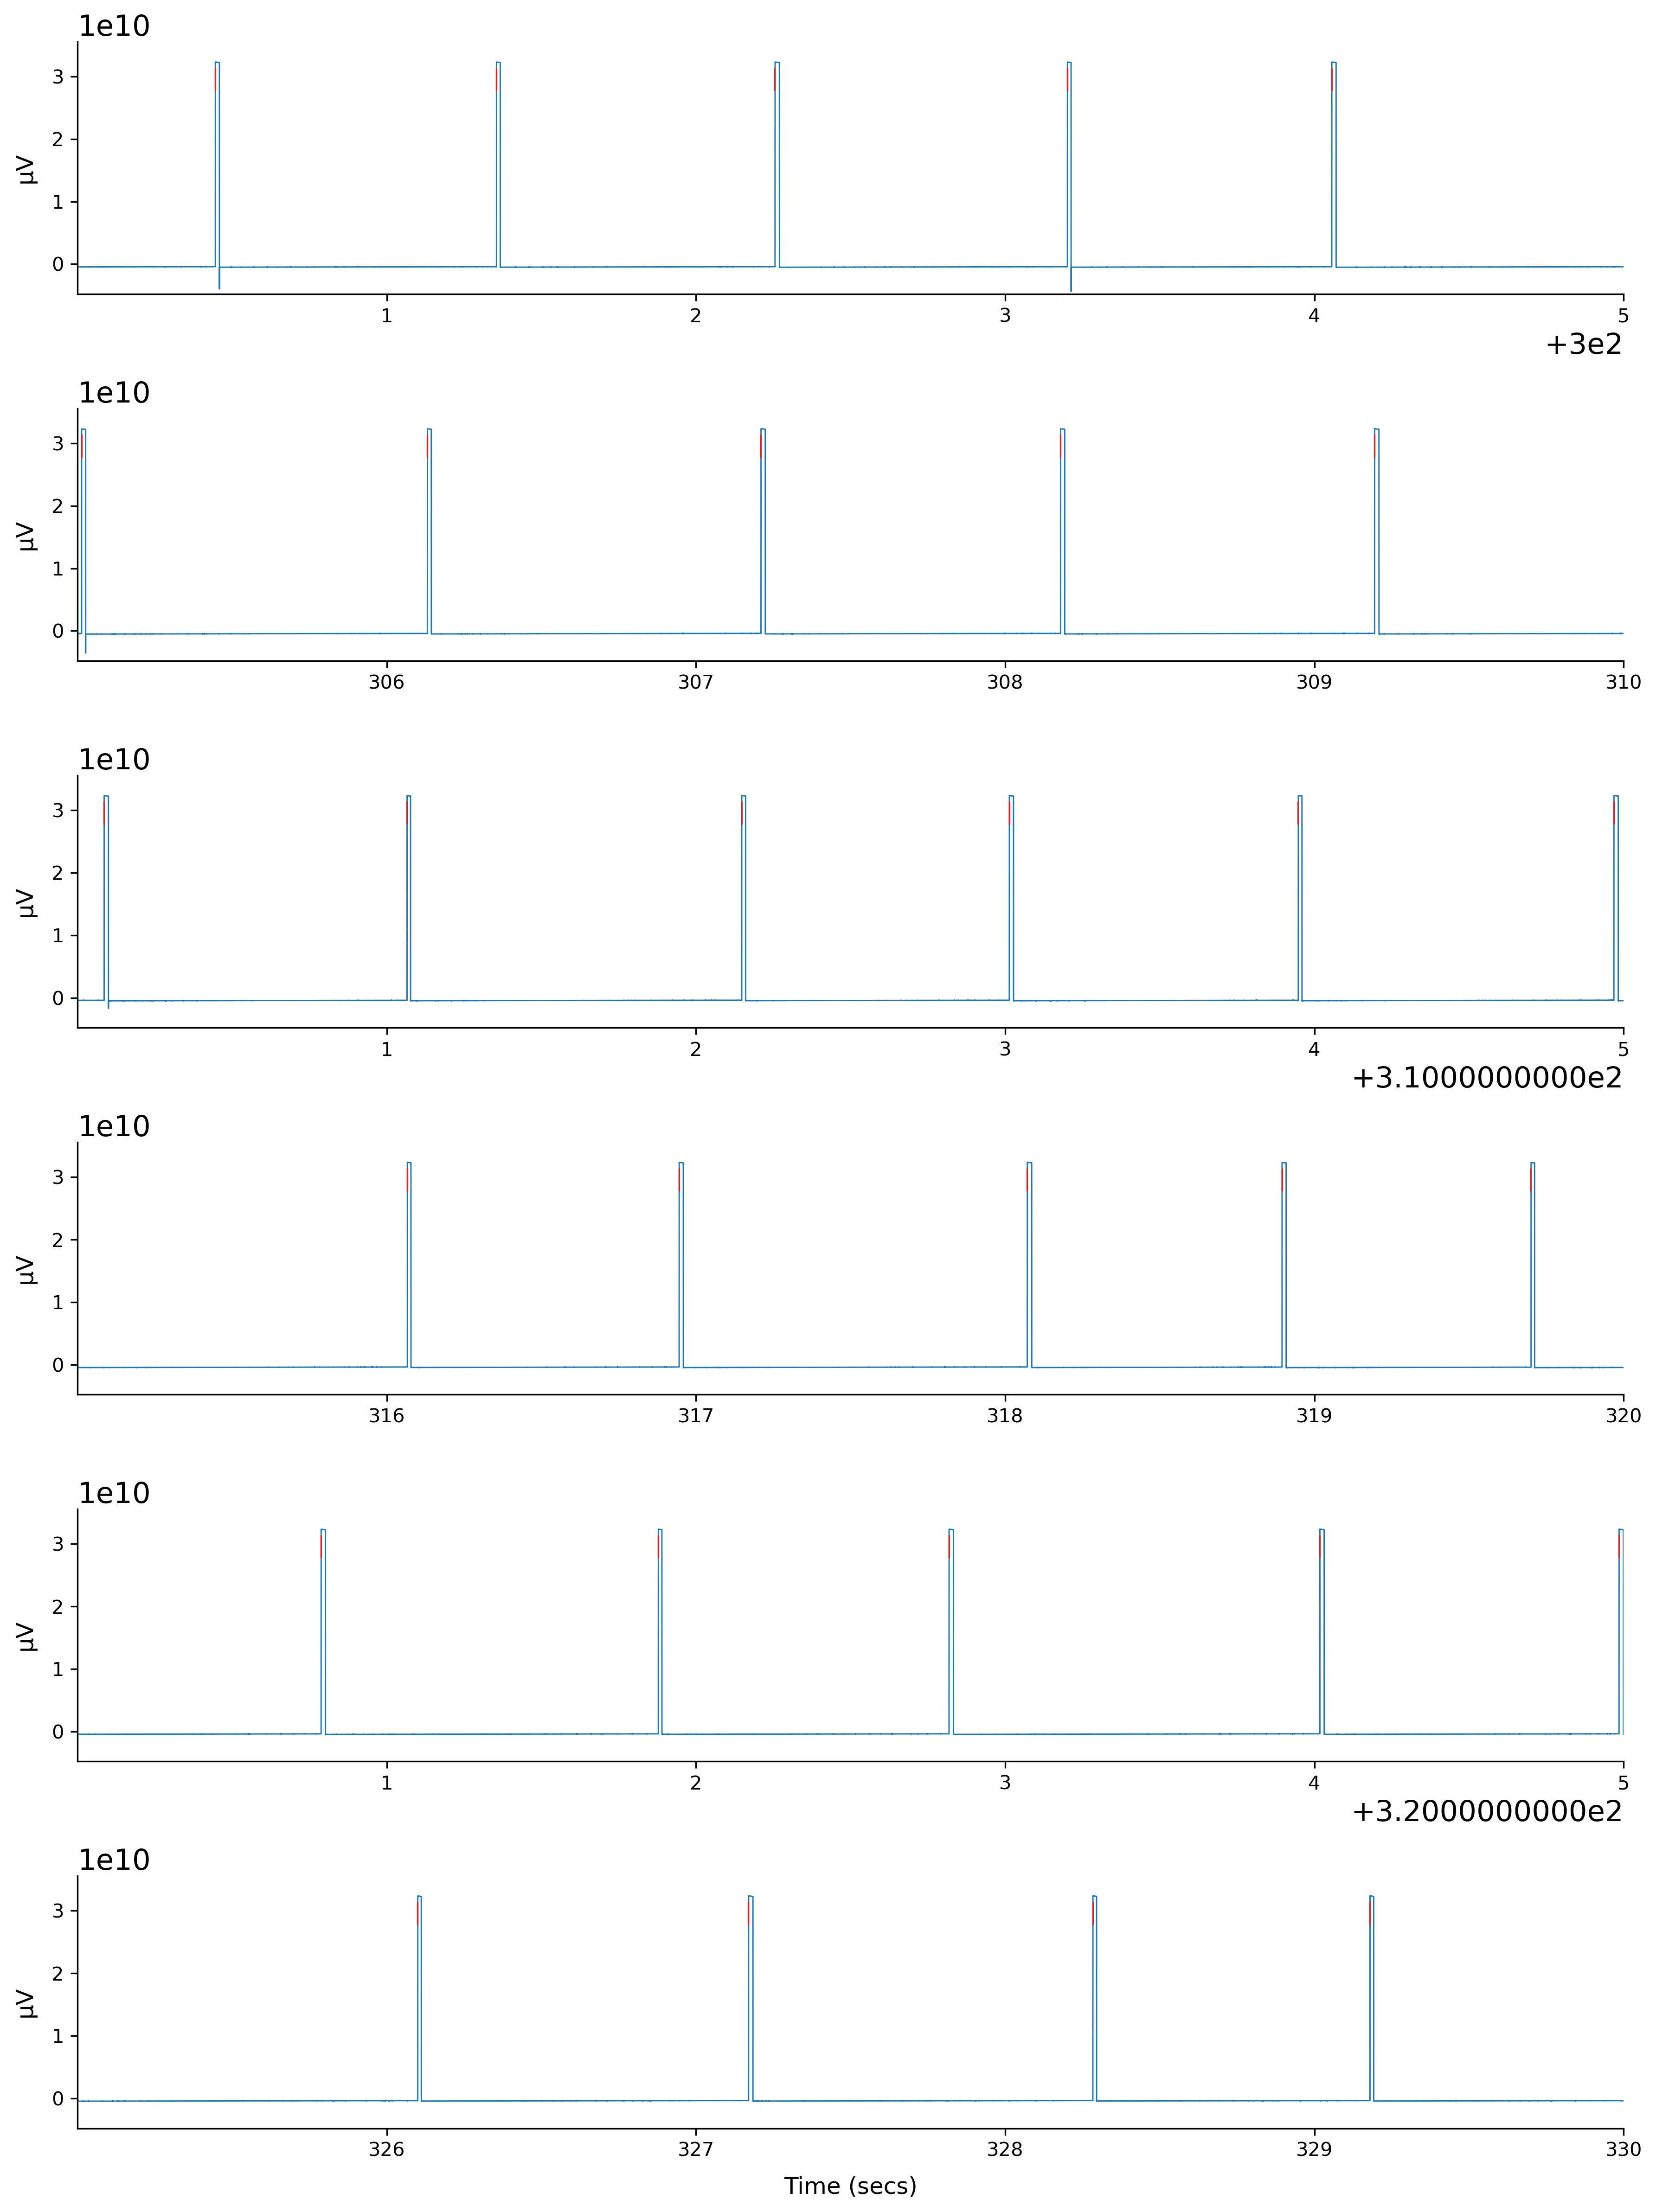

In [4]:
event_synctimes = events.loc[events['key']=='syncPulse', 'time'].values
event_pulse_inds = (np.array([x for x in (event_synctimes-lfp_timestamps[0]) * (sr/1e3) 
                              if x<len(lfp_timestamps)])).astype(np.int64)
event_pulse_startinds_train = np.zeros(len(sync_chan))
event_pulse_startinds_train[event_pulse_inds] = 1

fig, ax = plot_trace2(sync_chan, spike_dat=event_pulse_startinds_train,
                      start=300, duration=30, nwin=6, x_units='secs', sampling_rate=sr)

## Format events and spikes

In [5]:
proc_events = 0
proc_spikes = 1
proj_dir = '/home1/cjmac/projects/time_cells'
run_all = True
save_output = True
overwrite = False
verbose = True

start_time = time()
warnings.filterwarnings('ignore')

print(subj_sess)
if proc_events:
    # Load events and event times.
    print('Processing events data.', end='\n\n')
    events = events_preproc.format_events(events=events,
                                          noisy_trials=[],
                                          remove_incomplete_trials=True,
                                          remove_noisy_trials=False,
                                          remove_paused_trials=False,
                                          overwrite=overwrite,
                                          save_output=save_output,
                                          proj_dir=proj_dir,
                                          verbose=verbose)
    events = events_proc.load_events(subj_sess,
                                     proj_dir=proj_dir,
                                     overwrite=overwrite,
                                     verbose=verbose,
                                     run_all=run_all)
    if save_output:
        events_proc.save_events(events,
                                overwrite=overwrite,
                                verbose=verbose)
    
if proc_spikes:
    # Load spikes.
    print('Processing spikes data.', end='\n\n')
    spikes = spike_preproc.format_spikes(subj_sess,
                                         conv_factor='infer',
                                         fr_thresh=0.1,
                                         overwrite=True,
                                         save_output=True,
                                         split_files=True,
                                         verbose=verbose)

warnings.resetwarnings()
print('Done in {:.2f} s'.format(time() - start_time))

U540_ses0
Processing spikes data.

Conversion factor is 1
123945508 timestamps over 68 min and 51.5 s
Sampling rate is 30000 Hz
Found 64 wave_clus files.

Found 43 neurons
Firing rates:
count    43.000000
mean      1.719398
std       2.268151
min       0.137722
25%       0.388840
50%       1.105889
75%       2.000839
max      12.802562
Name: fr, dtype: float64

        unit  chan        fr
hemroi                      
LMH        6     4  0.505504
LpSMA      2     2  0.181652
RA         3     3  0.927988
RAH        8     5  0.719106
RFSG       8     4  0.565773
ROF        7     7  2.866018
RPC        3     3  1.923507
RpSMA      6     5  1.423569


PermissionError: [Errno 13] Permission denied: '/home1/dscho/projects/time_cells/analysis/spikes/U540_ses0-CSC3-unit1-spikes.pkl'

In [7]:
savefile = True
overwrite = False

event_spikes = time_bin_analysis.load_event_spikes(subj_sess, overwrite=overwrite)
if savefile:
    time_bin_analysis.save_event_spikes(event_spikes, overwrite=overwrite)

Creating EventSpikes
Saved /home1/dscho/projects/time_cells/analysis/events/U540_ses0-EventSpikes.pkl


In [9]:
def model_unit_fr_parallel(subj_sess_neuron):
    import sys
    import os
    from time import sleep
    import numpy as np
    sys.path.append('/home1/dscho/code/projects')
    from time_cells.time_bin_analysis import model_unit_fr
    
    # Take a nap.
    if False:
        sleep_secs = int(1800 * np.random.rand())
        sleep(sleep_secs)
    try:
        subj_sess, chan, unit = subj_sess_neuron.split('-')
        neuron = '{}-{}'.format(chan, unit)
        output = model_unit_fr(subj_sess,
                               neuron,
                               model='ols',
                               n_perm=1000,
                               overwrite=False,
                               save_output=True)
    except:
        err = sys.exc_info()
        errf = '/home1/dscho/logs/TryExceptError-model_unit_fr_parallel-{}'.format(subj_sess_neuron)
        os.system('touch {}'.format(errf))
        with open(errf, 'w') as f:
            f.write(str(err) + '\n')
    
    return None

start_time = time()

# Load event_spikes and get the names of each neuron.
proj_dir = '/home1/dscho/projects/time_cells'

# Get sessions.
sessions = np.unique([op.basename(f).split('-')[0] 
                      for f in glob(op.join(proj_dir, 'analysis', 'events', '*.pkl'))])
print('{} subjects, {} sessions'.format(len(np.unique([x.split('_')[0] for x in sessions])), len(sessions)))

subj_sess_neurons = []
for subj_sess in sessions:
    event_spikes = time_bin_analysis.load_event_spikes(subj_sess, verbose=False)
    for neuron in event_spikes.column_map['neurons']:
        subj_sess_neuron = '{}-{}'.format(subj_sess, neuron)
        #output_f = op.join(proj_dir, 'analysis', 'behav_glms', '{}-glm_results.pkl'.format(subj_sess_neuron))
        output_f = op.join(proj_dir, 'analysis', 'unit_to_behav', '{}-ols-time_bin-model_pairs.pkl'.format(subj_sess_neuron))
        if not op.exists(output_f):
            subj_sess_neurons.append(subj_sess_neuron)
print('{} neurons'.format(len(subj_sess_neurons)))

# Parallel processing
for subj_sess_neuron in subj_sess_neurons:
    _start_time = time()
    print(subj_sess_neuron)
    _ = model_unit_fr_parallel(subj_sess_neuron)
    print('{:.1f}s'.format(time() - start_time))

print('Done in {:.1f}s')

9 subjects, 11 sessions
3 neurons
U518_ses0-9-1
Loading saved EventSpikes file
486.7s
U518_ses0-13-2
Loading saved EventSpikes file
956.2s
U518_ses0-36-1
Loading saved EventSpikes file
1427.9s
Done in {:.1f}s
